In [ ]:
#==========================================
#=======Decision Tree Regressor (DTR)======
#==========================================

In [ ]:
#import libaries
import pandas as pd   #handle data tables easily
import numpy as np    #fast math calculations
import time           #measure training time
#create simple visual plots
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn -> main ML library used for preprocessing, training & evaluation
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler # scales features (important for SVR)
from sklearn.pipeline import Pipeline            # links steps (scaling + model)
from sklearn.model_selection import (
    RandomizedSearchCV, TimeSeriesSplit, KFold, cross_val_score
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Progress Review 2 & 3_Pgno68/processed_final_scaled.csv',
                 parse_dates=['datetime'], index_col='datetime').sort_index()

#Define features (X) and target (y)
target_col = 'Global_active_power_log'
feature_cols = [
    'Global_reactive_power_log', 'Voltage_log', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'lag_1', 'lag_60', 'lag_1440', 'roll_mean_60', 'roll_std_60',
    'PC1', 'PC2', 'PC3', 'PC4', 'PC5'
]
X = df[feature_cols]
y = df[target_col]

Mounted at /content/drive


In [ ]:
#Train-Test Split (80% train, 20% test)
split_index = int(len(df)*0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [ ]:
# Define helper functions
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rae = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))
    return rmse, mae, r2, rae

def train_test_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    rmse_train, mae_train, r2_train, rae_train = metrics(y_train_true, y_train_pred)
    rmse_test, mae_test, r2_test, rae_test = metrics(y_test_true, y_test_pred)
    return rmse_train, mae_train, r2_train, rae_train, rmse_test, mae_test, r2_test, rae_test

def tss_cv_rmse(pipe, X, y, n_splits=5, sample_frac=0.005):
    tss = TimeSeriesSplit(n_splits=n_splits)
    X_sample = X.sample(frac=sample_frac, random_state=42)
    y_sample = y.sample(frac=sample_frac, random_state=42)
    scores = -cross_val_score(pipe, X_sample, y_sample, cv=tss,
                              scoring='neg_root_mean_squared_error', n_jobs=-1)
    return scores.mean()

# Results storage
results = []
sample_frac_train = 0.012
sample_frac_tune = 0.01


In [ ]:
# Results storage
results = []
sample_frac_train = 0.012
sample_frac_tune = 0.01

In [ ]:
#==========================================================
# VARIATION 1 - Basic DTR (Default Params)
#==========================================================
pipe1 = Pipeline([
    ('scaler', StandardScaler()),
    ('dtr', DecisionTreeRegressor(random_state=42))
])

start = time.time()
pipe1.fit(X_train.sample(frac=sample_frac_train, random_state=42),
          y_train.sample(frac=sample_frac_train, random_state=42))
end = time.time()

# Predictions
y_pred_train1 = pipe1.predict(X_train)
y_pred_test1 = pipe1.predict(X_test)

# Metrics
rmse_train1, mae_train1, r2_train1, rae_train1, rmse_test1, mae_test1, r2_test1, rae_test1 = \
    train_test_metrics(y_train, y_pred_train1, y_test, y_pred_test1)

# TimeSeriesSplit CV
cv_rmse1 = tss_cv_rmse(pipe1, X_train, y_train, n_splits=5)

results.append(['Variation 1 - Basic DTR', rmse_train1, mae_train1, r2_train1, rae_train1,
                 rmse_test1, mae_test1, r2_test1, rae_test1, end-start, cv_rmse1])

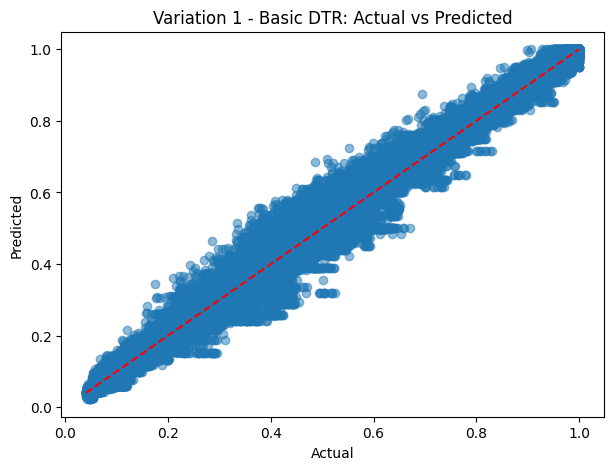

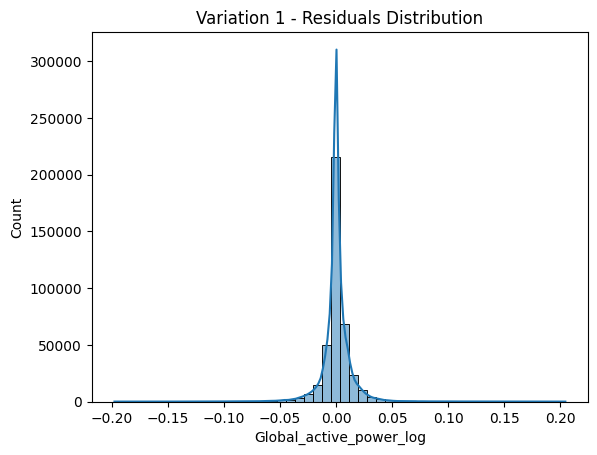

In [ ]:
# Plot Predicted vs Actual
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_test1, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Variation 1 - Basic DTR: Actual vs Predicted')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.show()

# Residual Plot
residuals1 = y_test - y_pred_test1
sns.histplot(residuals1, bins=50, kde=True)
plt.title('Variation 1 - Residuals Distribution')
plt.show()

In [ ]:
#==========================================================
# VARIATION 2 - Tuned DTR (RandomizedSearchCV)
#==========================================================
param_dist = {
    'dtr__max_depth': [5, 10, 20, None],
    'dtr__min_samples_split': [2, 5, 10],
    'dtr__min_samples_leaf': [1, 2, 4],
    'dtr__criterion': ['squared_error', 'friedman_mse', 'absolute_error']
}

tscv = TimeSeriesSplit(n_splits=3)
pipe2 = Pipeline([('scaler', StandardScaler()), ('dtr', DecisionTreeRegressor(random_state=42))])

search = RandomizedSearchCV(pipe2, param_distributions=param_dist,
                            n_iter=8, cv=tscv, n_jobs=-1,
                            scoring='neg_root_mean_squared_error', random_state=42)

start = time.time()
search.fit(X_train.sample(frac=sample_frac_tune, random_state=42),
           y_train.sample(frac=sample_frac_tune, random_state=42))
end = time.time()

best_params2 = search.best_params_
print("Best parameters (Variation 2):", best_params2)

pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('dtr', DecisionTreeRegressor(
        random_state=42,
        max_depth=best_params2['dtr__max_depth'],
        min_samples_split=best_params2['dtr__min_samples_split'],
        min_samples_leaf=best_params2['dtr__min_samples_leaf'],
        criterion=best_params2['dtr__criterion']
    ))
])

start = time.time()
pipe2.fit(X_train.sample(frac=sample_frac_train, random_state=43),
          y_train.sample(frac=sample_frac_train, random_state=43))
end = time.time()

# Predictions
y_pred_train2 = pipe2.predict(X_train)
y_pred_test2 = pipe2.predict(X_test)

# Metrics
rmse_train2, mae_train2, r2_train2, rae_train2, rmse_test2, mae_test2, r2_test2, rae_test2 = \
    train_test_metrics(y_train, y_pred_train2, y_test, y_pred_test2)

cv_rmse2 = tss_cv_rmse(pipe2, X_train, y_train, n_splits=5)

results.append(['Variation 2 - Tuned DTR', rmse_train2, mae_train2, r2_train2, rae_train2,
                 rmse_test2, mae_test2, r2_test2, rae_test2, end-start, cv_rmse2])

Best parameters (Variation 2): {'dtr__min_samples_split': 10, 'dtr__min_samples_leaf': 4, 'dtr__max_depth': 20, 'dtr__criterion': 'friedman_mse'}


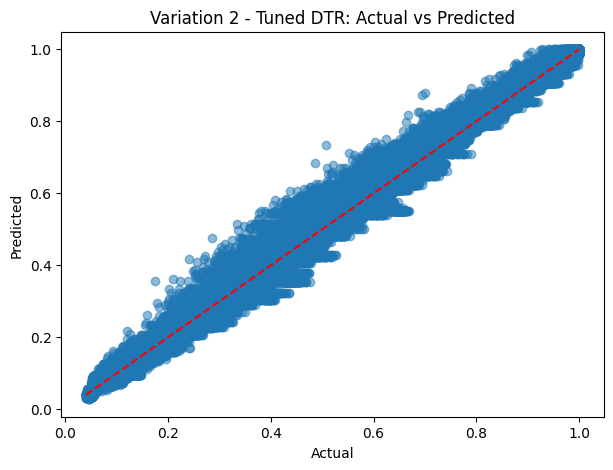

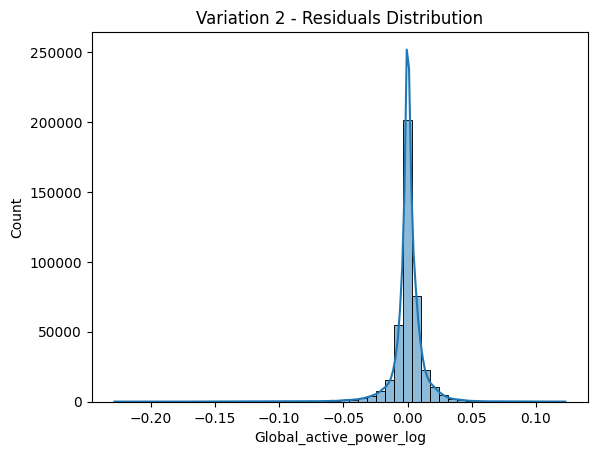

In [ ]:
#Plot Predicted vs Actual
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_test2, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Variation 2 - Tuned DTR: Actual vs Predicted')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.show()

# Residual Plot
sns.histplot(y_test - y_pred_test2, bins=50, kde=True)
plt.title('Variation 2 - Residuals Distribution')
plt.show()

In [ ]:
#==========================================================
# VARIATION 3 - Regularized DTR (Manually constrained)
#==========================================================
pipe3 = Pipeline([
    ('scaler', StandardScaler()),
    ('dtr', DecisionTreeRegressor(
        random_state=44,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        criterion='friedman_mse'))
])

start = time.time()
pipe3.fit(X_train.sample(frac=sample_frac_train, random_state=44),
          y_train.sample(frac=sample_frac_train, random_state=44))
end = time.time()

# Predictions
y_pred_train3 = pipe3.predict(X_train)
y_pred_test3 = pipe3.predict(X_test)

# Metrics
rmse_train3, mae_train3, r2_train3, rae_train3, rmse_test3, mae_test3, r2_test3, rae_test3 = \
    train_test_metrics(y_train, y_pred_train3, y_test, y_pred_test3)

cv_rmse3 = tss_cv_rmse(pipe3, X_train, y_train, n_splits=5)

results.append(['Variation 3 - Regularized DTR', rmse_train3, mae_train3, r2_train3, rae_train3,
                 rmse_test3, mae_test3, r2_test3, rae_test3, end-start, cv_rmse3])


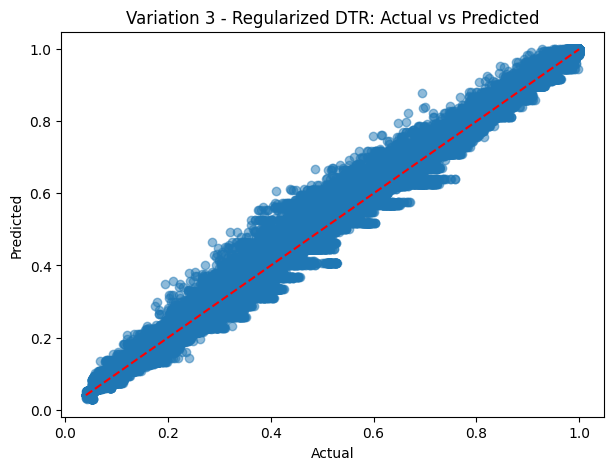

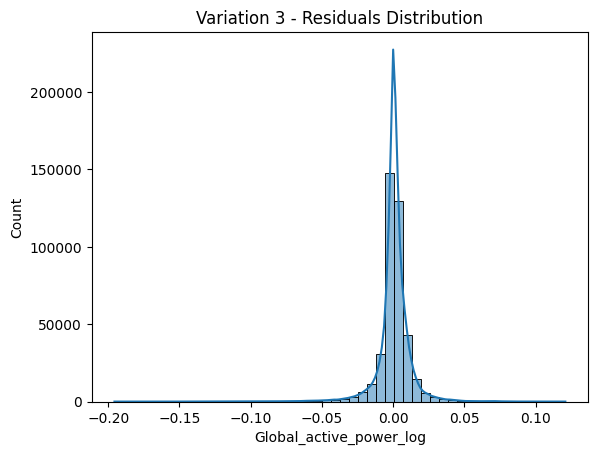

In [ ]:
# Plot
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_test3, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Variation 3 - Regularized DTR: Actual vs Predicted')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.show()

sns.histplot(y_test - y_pred_test3, bins=50, kde=True)
plt.title('Variation 3 - Residuals Distribution')
plt.show()


=== Decision Tree Regressor Variations: Results ===


,Variation,RMSE_train,MAE_train,R2_train,RAE_train,RMSE_test,MAE_test,R2_test,RAE_test,Time_sec,CV_RMSE
0,Variation 1 - Basic DTR,0.013114,0.006641,0.998063,0.024822,0.013847,0.007436,0.997318,0.031131,0.729854,0.014314
1,Variation 2 - Tuned DTR,0.011389,0.006066,0.998539,0.022673,0.012400,0.006891,0.997849,0.028847,0.549945,0.012945
2,Variation 3 - Regularized DTR,0.011431,0.006157,0.998528,0.023013,0.012301,0.006804,0.997883,0.028484,0.664183,0.012953


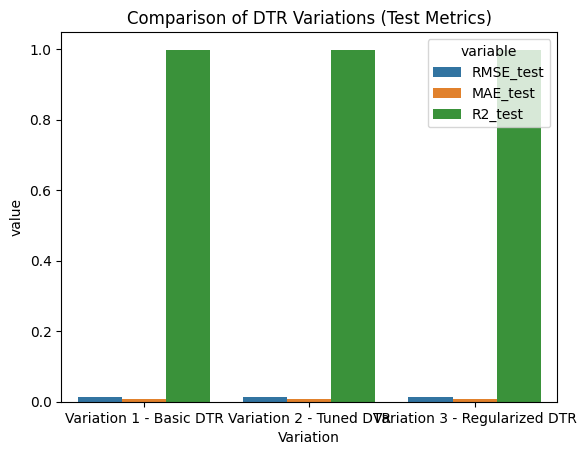

In [ ]:
#==========================================================
# EVALUATION & COMPARISON
#==========================================================
metrics_columns = [
    'Variation', 'RMSE_train', 'MAE_train', 'R2_train', 'RAE_train',
    'RMSE_test', 'MAE_test', 'R2_test', 'RAE_test', 'Time_sec', 'CV_RMSE'
]

res_df_final = pd.DataFrame(results, columns=metrics_columns)
print("\n=== Decision Tree Regressor Variations: Results ===")
display(res_df_final)

# Bar comparison
res_df_melt = res_df_final.melt(id_vars='Variation',
                                value_vars=['RMSE_test', 'MAE_test', 'R2_test'])
sns.barplot(data=res_df_melt, x='Variation', y='value', hue='variable')
plt.title("Comparison of DTR Variations (Test Metrics)")
plt.show()

In [ ]:
#==========================================================
# CONCLUSION
#==========================================================
best_model = res_df_final.sort_values(['R2_test', 'RMSE_test'], ascending=[False, True]).iloc[0]
print("\n=== Best Performing Variation ===")
print(f"Variation: {best_model['Variation']}")
print(f"Test RMSE: {best_model['RMSE_test']:.4f}")
print(f"Test R2: {best_model['R2_test']:.4f}")
print(f"CV RMSE: {best_model['CV_RMSE']:.4f}")

print("\nObservations:")
print("- Compare train vs test metrics to detect overfitting.")
print("- Tuned DTR (Variation 2) often gives best balance.")
print("- Regularized DTR (Variation 3) improves generalization.")
print("- Validation via TimeSeriesSplit gives robust RMSE estimate.")


=== Best Performing Variation ===
Variation: Variation 3 - Regularized DTR
Test RMSE: 0.0123
Test R2: 0.9979
CV RMSE: 0.0130

Observations:
- Compare train vs test metrics to detect overfitting.
- Tuned DTR (Variation 2) often gives best balance.
- Regularized DTR (Variation 3) improves generalization.
- Validation via TimeSeriesSplit gives robust RMSE estimate.
